Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory



In [3]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [7]:
# ## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

# ##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [10]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/CNN_assignment/skin/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/CNN_assignment/skin/Test")

In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

Use 80% of the images for training, and 20% for validation.

In [13]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# train_ds = ##todo

train_ds = image_dataset_from_directory(
    directory=data_dir_train,
    seed = 123,
    labels='inferred',
    validation_split = 0.2,
    subset = "training",
    label_mode='int',
    batch_size=batch_size,              # BATCH size = 32
    image_size=(img_height, img_width)) # Image Size = 180 x 180


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# val_ds = ##todo
val_ds = image_dataset_from_directory(
    directory=data_dir_train,
    seed = 123,
    labels='inferred',
    validation_split = 0.2,
    subset = "validation",
    label_mode='int',
    batch_size=batch_size, #BATCH size = 32
    image_size=(img_height, img_width)) # Image Size = 180 x 180

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

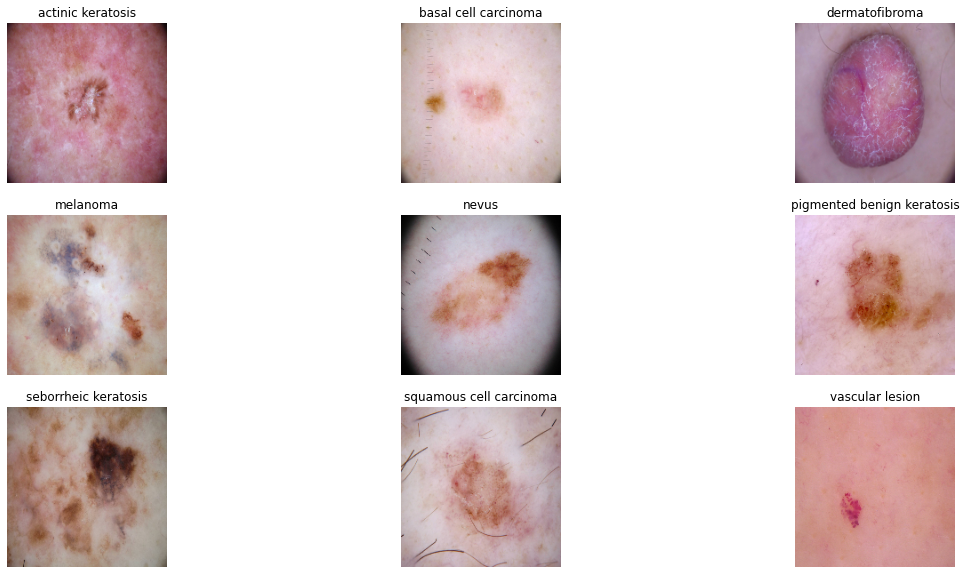

In [16]:
def format_example(x,l):
    return tf.math.equal(l[0], i)

fig = plt.figure(figsize=(20,10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(tf.autograph.experimental.do_not_convert(format_example))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [19]:
### Your code goes here
# RESCALE --> CONV--> MaxPool ---> CONV--> MaxPool --> Flatten --> Dense ---> Dense ---> Output (activativation)
model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes)) # Last Dense Layer has 9 nodes because there are 9 classes. 
model.add(Activation('softmax')) #Softmax chosen because it's a multinomial logistic regression, and we have 9 classes


### Compile the model
Choose an appropirate optimiser and loss function for model training 

### Loss Function: Sparse Categorical CrossEntropy

- sparse_categorical_crossentropy (scce) produces a category index of the most likely matching category
- Literature also says that if dataset label_mode is "int" then it is best to go for sparse categorical crossEntropy


### Optimizer: Adam

- ADAM (Adaptive Moment) Estimation is an algorithm for optimization technique for gradient descent. The method is **really efficient when working with large problem involving a lot of data or parameters**. It requires less memory and is efficient

- Our CNN architecture has Trainable params: 66,379,721. 

In [20]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy", 
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 90, 90, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0

### Train the model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size = batch_size,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 122s 1s/step - loss: 3.7423 - accuracy: 0.2081 - val_loss: 1.8855 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.7743 - accuracy: 0.3510 - val_loss: 2.0818 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4656 - accuracy: 0.5000 - val_loss: 1.5925 - val_accuracy: 0.4698
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4031 - accuracy: 0.4972 - val_loss: 1.4391 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2178 - accuracy: 0.5692 - val_loss: 1.5528 - val_accuracy: 0.4541
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.0695 - accuracy: 0.6412 - val_loss: 1.4577 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 0.9396 - accuracy: 0.6735 - val_loss: 1.6506 - val_accuracy: 0.5078
Epoch 8/20
56

### Visualizing training results

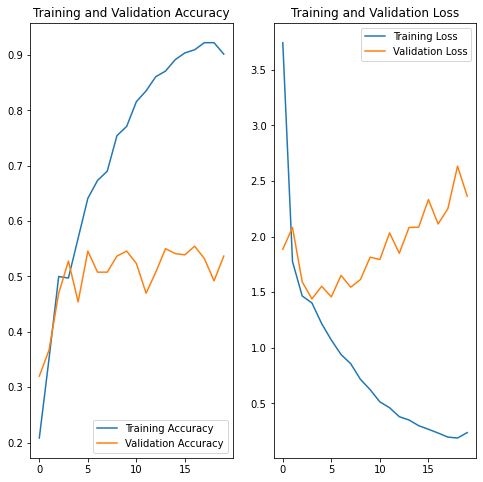

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

- There is severe overfitting present in our data
- Training accuracy is hovering around 91 to 93% but validation accuracy is merely around 53%. 
- Though further investigation is required to understand the proper reason but most probable causes: 
    - Dearth of data. We have small dataset which is further divided to training and validation
    - Our model is "memorising" the dataset. There is a need to add more variety to our dataset. 
    - Class distribution should also be checked. 

In [24]:
# ------------------------------------------------------------------------------------- #

In [25]:
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomTranslation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomHeight
from tensorflow.keras.layers.experimental.preprocessing import RandomWidth

### Augmentation Layers
All the chosen image augmentation layers do not tamper the image size but tweak the image enough within the size constraint to make the image different and make the model invariant to changes. 

In [26]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = tf.keras.Sequential([
  RandomRotation(seed=123, factor=(-0.1, 0.1) ),
  RandomTranslation(seed=123, height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1) ),
  RandomFlip( mode="horizontal_and_vertical", seed=123 ),
  RandomZoom( seed=123, height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1) )
])



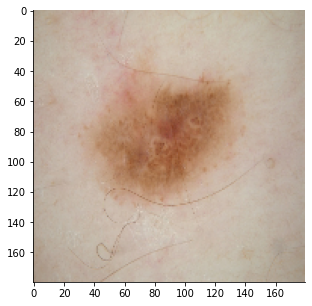

In [27]:
train_batch = train_ds.take(1)
fig = plt.figure(figsize=(10,5))
for images, label in train_batch:
    for i in range(1):
        myPic = images[i].numpy().astype("uint8")
        plt.imshow(myPic)
        sns.despine()

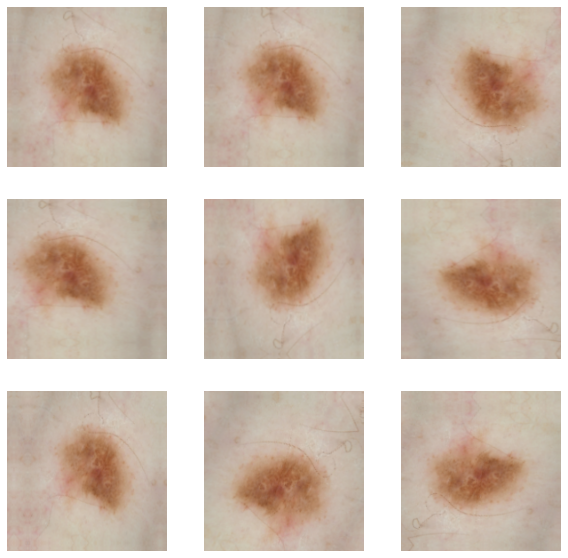

In [28]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(images)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.array(augmented_image[0],np.int32))
  plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [29]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3))) # Normalisation layer

#Augmentation Layers
model.add(RandomRotation(seed=123, factor=(-0.1, 0.1) ))
model.add(RandomTranslation(seed=123, height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1) ))
model.add(RandomFlip( mode="horizontal_and_vertical", seed=123 ))
model.add(RandomZoom( seed=123, height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1) ))



model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1)) # Adding Dropouts because we know there is overfitting. 

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())


model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(num_classes))
model.add(Activation('softmax'))




### Compiling the model

In [30]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_translation_1 (Random (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
activation_4 (Activation)    (None, 180, 180, 32)     

### Training the model

In [32]:
## Your code goes here, note: train your model for 20 epochs
# history = ## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs = epochs,
)

Epoch 1/20
56/56 [==============================] - 3s 33ms/step - loss: 3.8444 - accuracy: 0.2511 - val_loss: 1.8205 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.7577 - accuracy: 0.3744 - val_loss: 1.7594 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6436 - accuracy: 0.4107 - val_loss: 1.6361 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5362 - accuracy: 0.4704 - val_loss: 1.4836 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4695 - accuracy: 0.4872 - val_loss: 1.5034 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4876 - accuracy: 0.4955 - val_loss: 1.5202 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4131 - accuracy: 0.5061 - val_loss: 1.5455 - val_accuracy: 0.4877
Epoch 8/20
56

### Visualizing the results

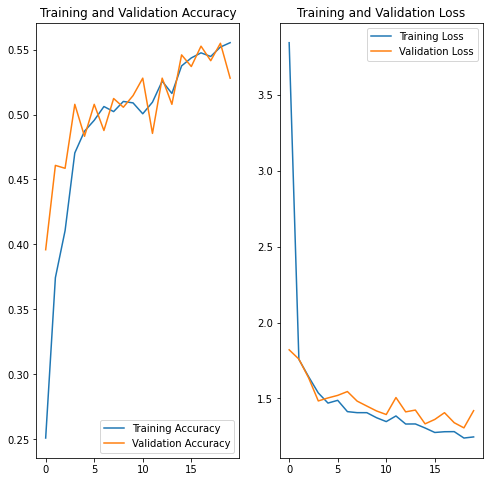

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- We have successfully removed Overfitting from our model by adding Augmentation layers. 

- Though the overfitting has now gone, the model seems to be underfitting with only 56.08% Training Data Accuracy and 56.80% Validation Data Accuracy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [34]:
## Your code goes here.

train_ds_2 = image_dataset_from_directory(
    directory=data_dir_train,
    seed = 123,
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(img_height, img_width))

Found 2239 files belonging to 9 classes.


In [35]:
labelCount = []

for image, label in train_ds_2.take(-1):
    labelCount.append(class_names[label.numpy()[0]])

len(labelCount)

2239

In [36]:
def CountFrequency(my_list):
     
    # Creating an empty dictionary
    freq = {}
    for items in my_list:
        freq[items] = my_list.count(items)

    return freq

In [37]:
freq = CountFrequency(labelCount)
freq

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [38]:
def annotate_graph(ax):
    for bar in ax.patches:         
        ax.annotate(format((bar.get_height()), '.1f'), 
                    (bar.get_x() + bar.get_width() / 2,  bar.get_height()),                    
                    ha='center', va='center',                    
                    size=10, xytext=(0, 8),                    
                    textcoords='offset points')     
    return ax


In [39]:
keys = list(freq.keys())

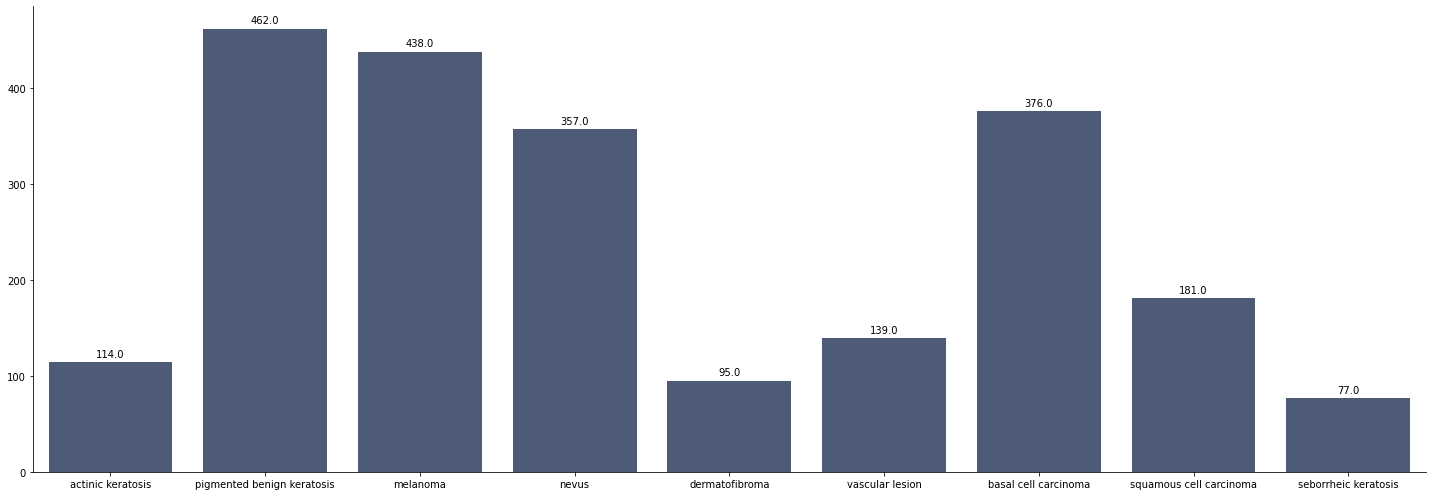

In [40]:
fig = plt.figure(figsize=(20,7))
ax = sns.barplot(x = keys, y=[freq[k] for k in keys], color = "#47597E")
ax = annotate_graph(ax)
sns.despine()
plt.tight_layout()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

**Answer**: With 77 samples, Seborrheic Keratosis has the lest number of sampels


#### - Which classes dominate the data in terms proportionate number of samples?

**Answer**: With 462 samples, Pigmented Benign Keratosis has the highest number of Samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [41]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [42]:
path_to_training_dataset= str(data_dir_train)+"/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/CNN_assignment/skin/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F30F4223890>: 100%|██████████| 500/500 [00:20<00:00, 24.15 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/CNN_assignment/skin/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F30F42B9590>: 100%|██████████| 500/500 [00:20<00:00, 24.49 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/CNN_assignment/skin/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F30F42514D0>: 100%|██████████| 500/500 [00:21<00:00, 23.75 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/CNN_assignment/skin/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=722x540 at 0x7F318A046590>: 100%|██████████| 500/500 [01:46<00:00,  4.68 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/CNN_assignment/skin/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F30F4251110>: 100%|██████████| 500/500 [01:31<00:00,  5.49 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/CNN_assignment/skin/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F318A04EB90>: 100%|██████████| 500/500 [00:21<00:00, 23.01 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/CNN_assignment/skin/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F318A6EB250>: 100%|██████████| 500/500 [00:45<00:00, 10.89 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F318C9B4210>:   0%|          | 1/500 [00:00<01:16,  6.54 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/CNN_assignment/skin/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F318C9B4250>: 100%|██████████| 500/500 [00:20<00:00, 24.12 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/CNN_assignment/skin/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F318C8C7990>: 100%|██████████| 500/500 [00:20<00:00, 24.00 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
from glob import glob

In [45]:
path_list_old = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]


dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

original_df.Label.value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [46]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list_new 

In [47]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [48]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [49]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [50]:
#These are the new 500 samples added by Augmentator Package
df2.Label.value_counts()

dermatofibroma                500
pigmented benign keratosis    500
actinic keratosis             500
basal cell carcinoma          500
melanoma                      500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
nevus                         500
Name: Label, dtype: int64

In [51]:
#This is the addition of --> new 500 samples added by Augmentator Package + The original dataset(training+validation)
new_df = original_df.append(df2)
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

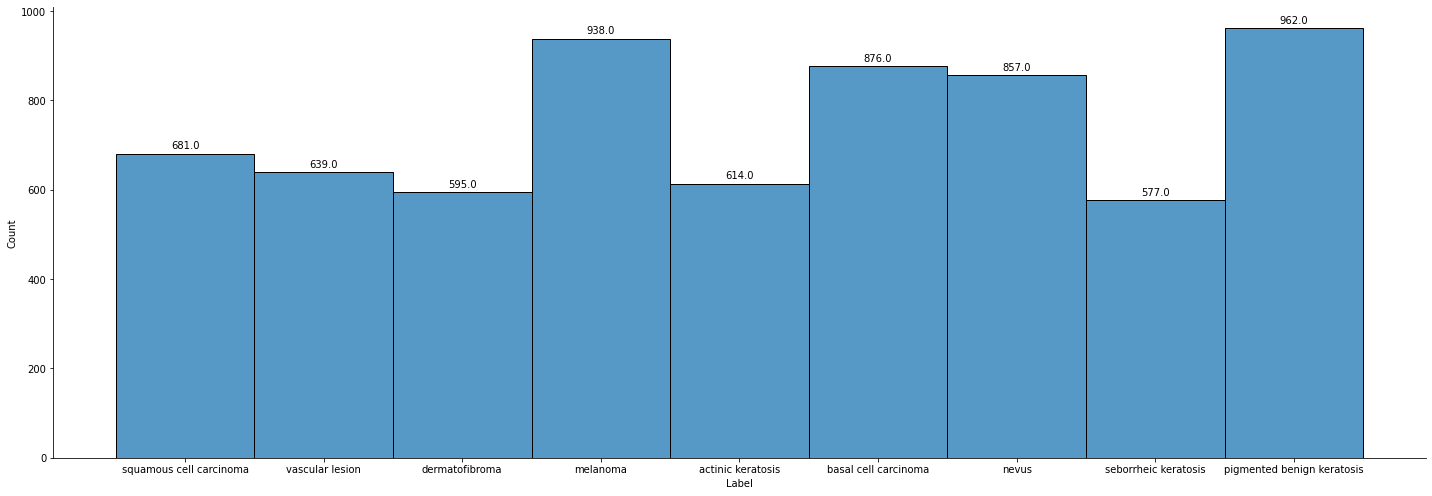

In [52]:
plt.figure(figsize=(20,7))
ax = sns.histplot(data=new_df, x="Label")
ax = annotate_graph(ax)
sns.despine()
plt.tight_layout()


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [53]:
batch_size = 32
img_height = 180
img_width = 180

In [54]:
import shutil
import os


In [55]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [56]:
# This function takes all the 500 samples for each class added by Augmentor Package, and moves it to 
# the main folder for each class. Therefore, now each folder will have all the samples in one place
for name in class_names:
    source = str(data_dir_train)+"/"+name+"/output"
    destination = str(data_dir_train)+ "/" + name
    
    files = os.listdir(source)
    
    for file in files:
        file_name = os.path.join(source, file)
        shutil.move(file_name, destination)

#### **Todo:** Create a training dataset

In [57]:
data_dir_train=str(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [59]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

#Augmentation Layers --> Not Required since Augmentor Package handles it to an extent but found better result when these were added. 
model.add(RandomRotation(seed=123, factor=(-0.1, 0.1) ))
model.add(RandomTranslation(seed=123, height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1) ))
model.add(RandomFlip( mode="horizontal_and_vertical", seed=123 ))
model.add(RandomZoom( seed=123, height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1) ))



model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())


model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(num_classes))
model.add(Activation('softmax'))




#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [60]:
## your code goes here
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [61]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_translation_2 (Random (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 180, 180, 32)     

#### **Todo:**  Train your model

In [62]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 39s 219ms/step - loss: 2.7501 - accuracy: 0.2192 - val_loss: 1.9914 - val_accuracy: 0.2532
Epoch 2/50
169/169 [==============================] - 37s 215ms/step - loss: 1.6887 - accuracy: 0.3479 - val_loss: 1.8045 - val_accuracy: 0.3415
Epoch 3/50
169/169 [==============================] - 36s 209ms/step - loss: 1.5555 - accuracy: 0.4036 - val_loss: 1.4537 - val_accuracy: 0.4417


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f3208d9d830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 4/50
169/169 [==============================] - 37s 210ms/step - loss: 1.4565 - accuracy: 0.4392 - val_loss: 1.3811 - val_accuracy: 0.4707
Epoch 5/50
169/169 [==============================] - 37s 211ms/step - loss: 1.4210 - accuracy: 0.4549 - val_loss: 1.4417 - val_accuracy: 0.4454
Epoch 6/50
169/169 [==============================] - 37s 210ms/step - loss: 1.3798 - accuracy: 0.4703 - val_loss: 1.3573 - val_accuracy: 0.5167
Epoch 7/50
169/169 [==============================] - 36s 208ms/step - loss: 1.3272 - accuracy: 0.4892 - val_loss: 1.3419 - val_accuracy: 0.5108
Epoch 8/50
169/169 [==============================] - 36s 207ms/step - loss: 1.3123 - accuracy: 0.5050 - val_loss: 1.2341 - val_accuracy: 0.5167
Epoch 9/50
169/169 [==============================] - 36s 208ms/step - loss: 1.2651 - accuracy: 0.5211 - val_loss: 1.2609 - val_accuracy: 0.5264
Epoch 10/50
169/169 [==============================] - 36s 208ms/step - loss: 1.2717 - accuracy: 0.5147 - val_loss: 1.2336 - val_a

#### **Todo:**  Visualize the model results

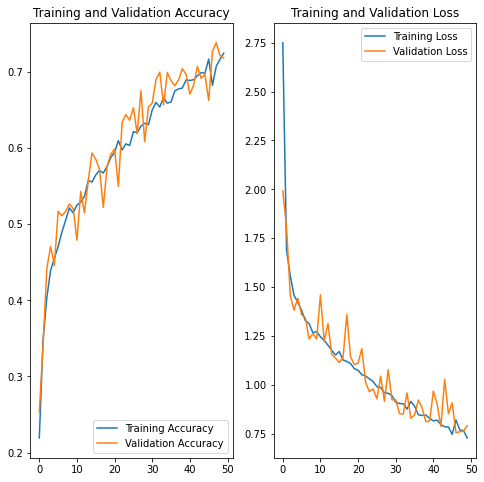

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## Observation

- We have removed overfitting by adding augmentation layers
- We have improved underfitting by adding new samples with slight rotations and changes using the Augmentor Package.
- Augmentor Package also helped us solve the severe class imbalance problem which was present before.


### Model 1 --> Over-Fitting

- Training Accuracy: 91%
- Validation Accuracy: 53%

### Model 2 --> Under-Fitting

- Training Accuracy: 56%
- Validation Accuracy: 56%

### Model 3 --> Fairly Decent Performer

- Training Accuracy: 74.5%
- Validation Accuracy: 73.8%
